# Ultimate Data Analysis Interview Challenge 
## Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df= pd.read_json('logins.json')
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df= pd.read_json('logins.json')
df['login_time']=pd.to_datetime(df['login_time'])
df.set_index('login_time', inplace = True)
df['count'] = 1
New=df.resample('15T', how = sum)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """


In [5]:
New['time'] = New.index.strftime('%H:%M:%S')
New.time.value_counts().head()

15:15:00    102
22:30:00    102
16:15:00    102
00:30:00    102
17:00:00    102
Name: time, dtype: int64

In [6]:
nMonth=df.index.month.nunique()
for i in range(1,nMonth+1):
    print(df[df.index.month==i].index.day.nunique())

31
28
31
13


#### We just have the first two weeks of month April.

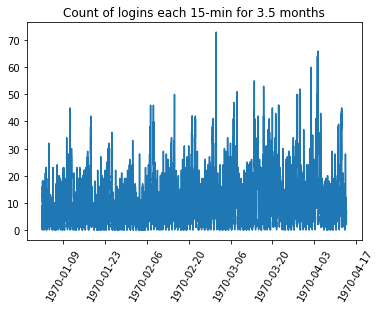

In [7]:
#plt.figure(figsize=(15,10))
x = New.index
y = New['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for 3.5 months')
plt.xticks(rotation=60);

#### There is not any special trend in the above plot.  I will check the trend monthly in next part.

### January

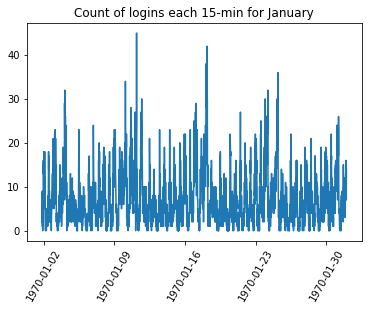

In [8]:
#plt.figure(figsize=(15,10))
x = New[New.index.month==1].index
y = New[New.index.month==1]['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for January')
plt.xticks(rotation=60);

### February

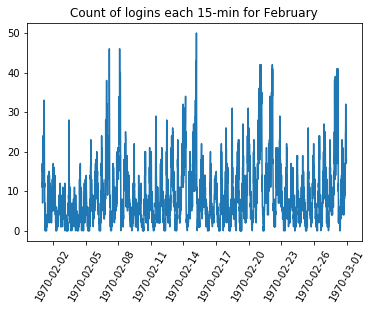

In [9]:
#plt.figure(figsize=(15,10))
x = New[New.index.month==2].index
y = New[New.index.month==2]['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for February')
plt.xticks(rotation=60);

#### It looks like that we have a weekly trend. Let's check that.

In [10]:
df= pd.read_json('logins.json')
df['login_time']=pd.to_datetime(df['login_time'])
df['Weekday']=df.login_time.dt.dayofweek
df['year']=df.login_time.dt.year
df['month']=df.login_time.dt.month
df['day']=df.login_time.dt.day
df['hour']=df.login_time.dt.hour

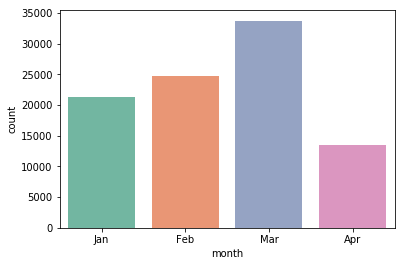

In [11]:
#plt.figure(figsize=(15,10))
a=sns.countplot(df['month'],palette="Set2")
a.set_xticklabels(['Jan','Feb','Mar','Apr'])
plt.show()


Our login counts have been recorded from 1st January, 1970 to 13th April, 1970. We can see that the number of logins has progressively increased over the months (April had just 13 days of activity recorded). This indicates an increasing user base.

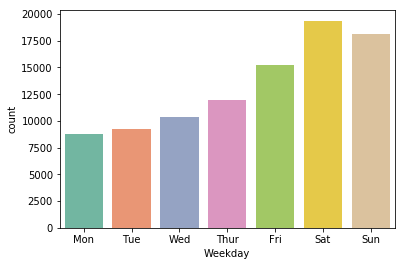

In [12]:
#plt.figure(figsize=(15,10))
a=sns.countplot(df['Weekday'],palette="Set2")
a.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.show()

#### There seems to be a trend here! Amount of logins increase as we near the weekend.

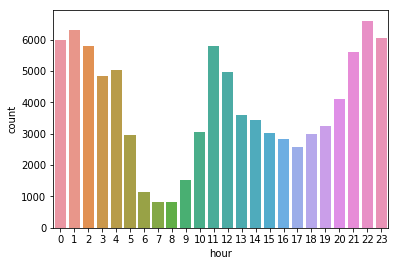

In [13]:
a=sns.countplot(df['hour'])
#a.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.show()

Lets check the time trend for every 15 mins.

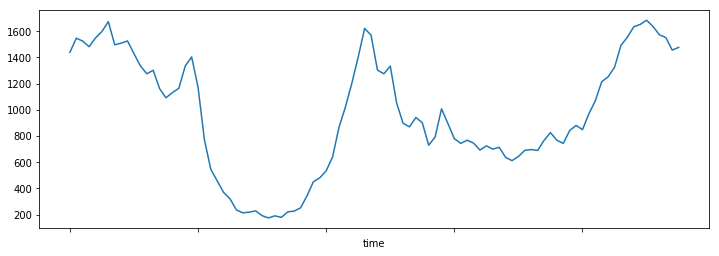

In [14]:
plt.figure(figsize=(12,4))
New.groupby('time')['count'].sum().plot()
plt.show()

The plot is kind of similar to the previous bar plot. So there is no extra information from this resampling.

### Conclusion for Part 1
 <span style="color:darkblue">  
__Amount of user-logins increase towards to the weekend.__
 <span style="color:darkblue">  
__Amount of user-logins increase during lunch time (11- am to noon) and during late-night (9 pm - 4 am)__

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Success Metric
 <span style="color:darkblue">  First lets assume the demand in both Gotham and Metropolis is same. We know that the demand in both the cities is complementary in the weekdays; i.e the demand for both cities can be met by the same driver partners as they are at different times. Therefore, if this experiment was indeed sucessful, it would indicate that the drivers, irrespective of which city they belong to, are spending equal amounts of time in Gotham and Metropolis during the weekdays; Metropolis during the day and Gotham during the night.

 <span style="color:darkblue">  The success metric could be the ratio of passengers taken from Gotham and Metropolis on weekdays. After the introduction of this experiment, if the ratio has regressed towards 1:1, it would mean that the experiment was successful.

### Practical Experiment

 <span style="color:darkblue"> These are the steps I will implement as part of an experiment to deduce if the policy changes have affected the behavior of the drivers.


 <span style="color:olive"> 1. Track the activity of every driver in each city. If the number of Gotham passengers for a particular driver is more, label it as a Gotham Driver. Else label as Metropolis Driver.

 <span style="color:olive"> 2. Calculate the proportion of passengers from two cities and divide them into two sample groups: before the experiment and after the experiment. 

 <span style="color:olive"> 3. Perform hypothesis testing using the **Difference of Proportions** test on the two samples. Calculate the Z-Statisitc and the p-value and compare it with an arbritrary significance level, $\alpha$.

 <span style="color:olive"> 4. If the Null Hypothesis holds, it implies that the experiment has been a failure. If the Alternate hypothesis holds, it implies that it has been a success.


 <span style="color:darkblue"> I will perform the experiment described above and test if the Null Hypothesis can be rejected for both groups. If this is true, then I will suggest that Ultimate Inc continue implementing this policy change. If it cannot be rejected, then I will suggest that they stop and look for other potent options.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [15]:
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
df= pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [18]:
# Impute in missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df1=df

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


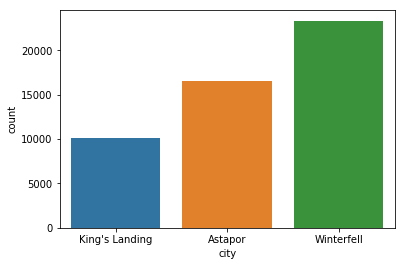

In [20]:
sns.countplot(df.city)
plt.show()

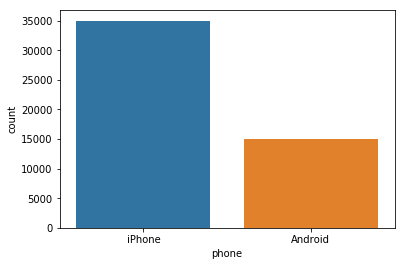

In [21]:
sns.countplot(df.phone)
plt.show()

In [22]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [23]:
df.retained=np.nan
df.loc[df['last_trip_date']>='2014-06-01 00:00:00','retained']=1
df.loc[df['last_trip_date']<'2014-06-01 00:00:00','retained']=0
df1=df

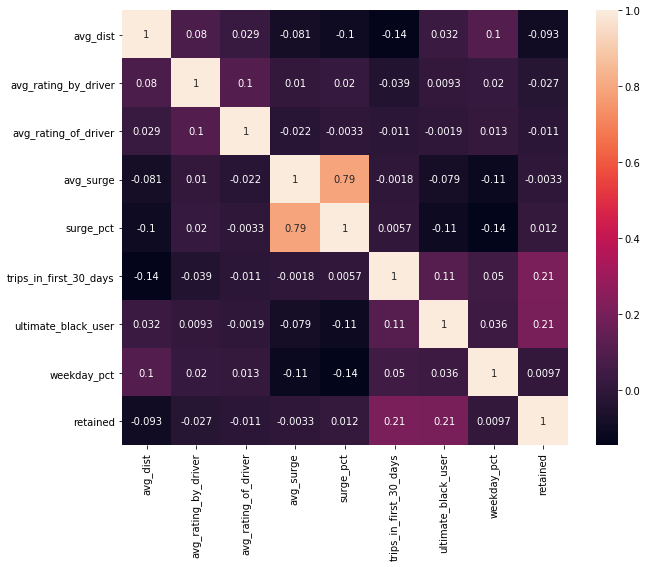

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

The target is related mostly to **'trips_in_first_30_days', and 
'ultimate_black_user'**.

The target is related mostly to **'trips_in_first_30_days', 'city_King's Landing','phone_iPhone', and 
'ultimate_black_user_True'**.

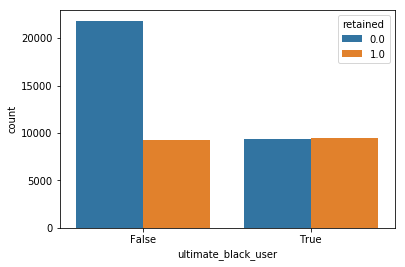

In [25]:
sns.countplot(x='ultimate_black_user', data=df, hue='retained')
plt.show()

**Ultimate Black Users** are much more likely to be retained as compared to the rest of the population.

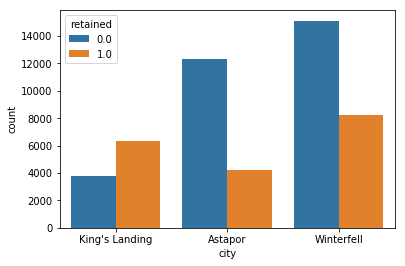

In [26]:
sns.countplot(x='city', data=df, hue='retained')
plt.show()

**King's Landing** seems to be especially successful in retaining users whereas Astapor is the least successful.

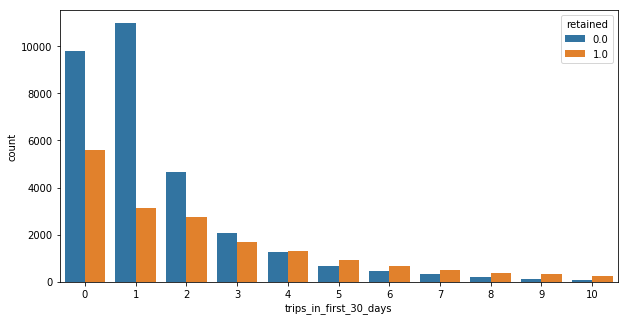

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='trips_in_first_30_days', data=df[df['trips_in_first_30_days']<=10],hue='retained')
plt.show()

For number of trips in first 30 days less than 4, people are not retained. However for number of trips in first 30 days more than or equal to 4, people are retained mostly.

### 1. What fraction of the observed users were retained?

In [28]:
print(round(df['retained'].sum()/len(df)*100,3),'% are retained')

37.608 % are retained


### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

First I change 'city', 'phone'' ultimate_black_user' columns to integer values.

In [29]:
df= pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0.0,0,0,1,1,0,1,0


I have to set the target (retained) and the input features. I have dropped the date columns from the dataframe.

In [30]:
y=df['retained'].values
X=df.drop(['last_trip_date','signup_date','retained'],axis=1)
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,1,0


I use the train_test_split from sklearn to set the train and test data and I have used the StandardScaler to scale the features.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=55)

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 


### Lets check different classifier techniques


### A. Gradient Boosting Classifier

In [32]:
GradClassifier = GradientBoostingClassifier(n_estimators=200)
GradClassifier.fit(X_train, y_train)
print('Correct accuracy with Gradient Boosting Classifier is:', round(GradClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
GradScores = cross_val_score(GradClassifier, X, y, cv=10)
end=time.time()
print('Gradient boosting score Mean with cross val is:',round(np.mean(GradScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Gradient Boosting Classifier is: 78.49 %
Gradient boosting score Mean with cross val is: 78.874 %
Total elapsed time is: 121.0475  sec


### B. AdaBoost Classifier

In [33]:
AdaClassifier = AdaBoostClassifier(n_estimators=200)
AdaClassifier.fit(X_train, y_train)
print('Correct accuracy with AdaBoost Classifier is:', round(AdaClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
AdaScores = cross_val_score(AdaClassifier, X, y, cv=10)
end=time.time()
print('Adaboost boosting score Mean with cross val is:',round(np.mean(AdaScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with AdaBoost Classifier is: 77.94 %
Adaboost boosting score Mean with cross val is: 78.246 %
Total elapsed time is: 84.161  sec



## C. Logistic Regression

In [34]:
LogClassifier= LogisticRegression(C=1)
LogClassifier.fit(X_train, y_train)
print('Correct accuracy with Logistic Regression is:', round(LogClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
LogScores = cross_val_score(LogClassifier, X, y, cv=10)
end=time.time()
print('Logistic Regression score Mean with cross val is:',round(np.mean(LogScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Logistic Regression is: 71.17 %
Logistic Regression score Mean with cross val is: 71.708 %
Total elapsed time is: 8.3272  sec


## D. Random Forest

In [35]:
RandClassifier= RandomForestClassifier(n_estimators=150)
RandClassifier.fit(X_train, y_train)
print('Correct accuracy with Random Forest Classifier is:', round(RandClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
RandScores = cross_val_score(RandClassifier, X, y, cv=10)
end=time.time()
print('Random Forest score Mean with cross val is:',round(np.mean(RandScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Random Forest Classifier is: 75.32 %
Random Forest score Mean with cross val is: 75.538 %
Total elapsed time is: 101.6328  sec


### E. KNN

In [36]:
KnnClassifier=KNeighborsClassifier(n_neighbors=15)
KnnClassifier.fit(X_train, y_train)
print('Correct accuracy with KNN Classifier is:', round(KnnClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
KnnScores = cross_val_score(KnnClassifier, X, y, cv=10)
end=time.time()
print('KNN score Mean with cross val is:',round(np.mean(KnnScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with KNN Classifier is: 75.45 %
KNN score Mean with cross val is: 76.276 %
Total elapsed time is: 11.0021  sec



 <span style="color:darkblue"> After checking different machine learning techniques, I got that **Gradient Boosting Classifier** provide the best score for our data however it is the slowest. **KNN** comparing scores, is the fastest.

#### Feature importance with Gradient Boosting

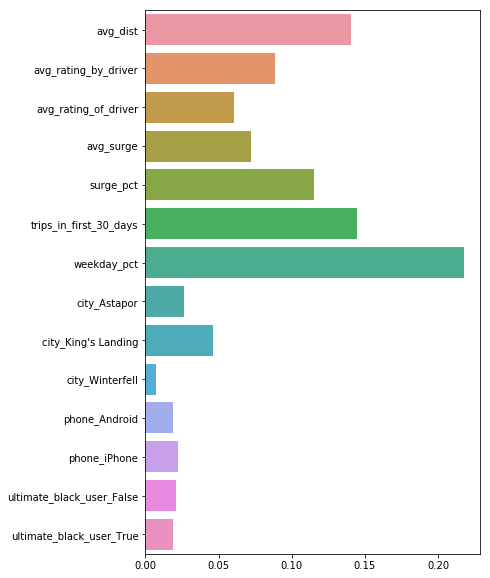

In [37]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=GradClassifier.feature_importances_)
plt.show()

The most importatn features base on the Gradient Boosting classifier is __'Weekday_pct', 'avg_dist', and 'trips_in_first_30_days'__.

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

### Recommendations


 <span style="color:olive"> 1. **King's Landing** seems to be especially successful in retaining users whereas Astapor is the least successful. Ultimate has to see what is unique about King's Landing drivers and passengers nd check if it can be implemented in the other cities, especially Astapor.


 <span style="color:olive"> 2. If the user has taken a **Ultimate Black**, it indicates that s/he is more likely to stay. Ultimate has to study what is the reason.


 <span style="color:olive"> 3. People who use cabs on the **weekdays** are more likely to be retained. This is the most important feature as discovered by our **Gradient Boosting Classifier**. Provide more offers in the weekdays to encourage people to take cabs to work.